In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay

In [2]:
# Which calibration type to analyse.
calibType = 'linearity'

# This cell should be edited to match the data to be inspected.
afwDisplay.setDefaultBackend("astrowidgets")

cameraName = 'LATISS'
genCollection = 'u/czw/DM-28920/linearityGen.20210713a'
genCollection2 = 'u/czw/DM-28920/linearityGen.20210713b'
ptcCollection = 'u/czw/DM-28920/ptcGen.20210714a'
ptcCollection2 = 'u/czw/DM-28920/ptcGen.20210714b'

/home/czw/.local/lib/python3.8/site-packages/ginga/cmap.py:13317: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for name in _cm.cmap_d:


In [3]:
# Get butler and camera
butler = dB.Butler("/repo/main/")
camera = butler.get('camera', instrument=cameraName, collections='LATISS/calib')

In [4]:
linA = butler.get('linearity', instrument='LATISS', detector=0, collections=genCollection)
linB = butler.get('linearity', instrument='LATISS', detector=0, collections=genCollection2)

In [5]:
ptcCollections = ['u/czw/DM-28920/ptcGen.20210712a','u/czw/DM-28920/ptcGen.20210712b']
ptcA = butler.get('ptc', instrument='LATISS', detector=0, collections=ptcCollections[0])
ptcB = butler.get('ptc', instrument='LATISS', detector=0, collections=ptcCollections[1])

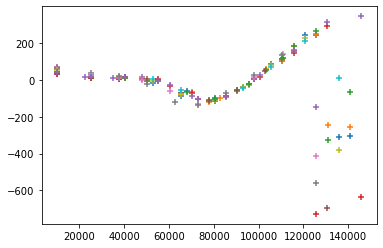

In [6]:
offset = 0
for it, amp in enumerate(camera[0].getAmplifiers()):
    if linA.linearityType[amp.getName()] == 'Spline':
        centers, values = np.split(linA.linearityCoeffs[amp.getName()], 2)
        plt.scatter(centers, values + it * offset, marker='+', label="LinA")

    if linB.linearityType[amp.getName()] == 'Spline':
        centers, values = np.split(linB.linearityCoeffs[amp.getName()], 2)
        plt.scatter(centers, values + it * offset, marker='x', label='LinB')
plt.show()

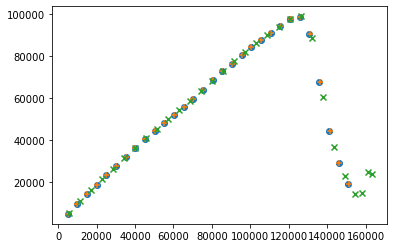

C00 Continue? [c, q]q


In [9]:
import lsst.afw.math as afwMath

continueDisplay=True
for amp in ptcA.ampNames:
    if linA.linearityType[amp] == 'Spline':
        centers, values = np.split(linA.linearityCoeffs[amp], 2)
        interp = afwMath.makeInterpolate(centers.tolist(), values.tolist(),
                                         afwMath.stringToInterpStyle("AKIMA_SPLINE"))
        delta = interp.interpolate(np.array(ptcA.rawMeans[amp]))
        linearized = np.array(ptcA.rawMeans[amp]) - np.array(delta)
    
    plt.scatter(linearized, ptcA.rawVars[amp], marker='o', label="PTCA")

    plt.scatter(ptcA.rawMeans[amp], ptcA.rawVars[amp], marker='+', label="PTCA")
    plt.scatter(ptcB.rawMeans[amp], ptcB.rawVars[amp], marker='x', label='PTCB')
    plt.show()
    
    while True:
        ans = input(f"{amp} Continue? [c, q]").lower()
        if ans in ("", "c",):
            break
        if ans in ('q', 'x'):
            continueDisplay = False
            break
    if continueDisplay is False:
        break

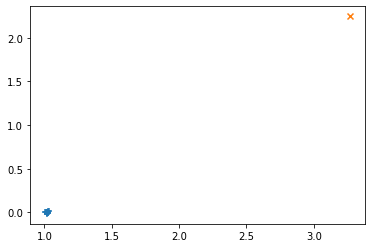

A Gain: ['1.015', '1.016', '1.027', '1.018', '1.007', '1.025', '1.024', 'nan', '1.020', '1.018', '1.020', '1.033', '1.028', '1.025', '1.029', '1.028']
A RN:   ['nan', 'nan', '3.626', 'nan', 'nan', '3.267', '1.806', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
B Gain: ['1.015', '1.018', '1.013', '1.018', '1.008', '1.027', '1.017', 'nan', '1.038', '1.024', '1.026', '1.021', '1.028', '1.025', '1.027', '1.037']
B RN:   ['0.959', 'nan', 'nan', 'nan', 'nan', '1.020', 'nan', 'nan', '8.090', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', '3.224']


In [10]:
plt.scatter(np.array(list(ptcA.gain.values())), 
            np.array(list(ptcA.gain.values())) - np.array(list(ptcB.gain.values())), 
            marker='+', label="PTCA")
plt.scatter(np.array(list(ptcA.noise.values())), 
            np.array(list(ptcA.noise.values())) - np.array(list(ptcB.noise.values())),
            marker='x', label='PTCB')
plt.show()
print("A Gain:", [f"{x:.3f}" for x in ptcA.gain.values()])
print("A RN:  ", [f"{x:.3f}" for x in ptcA.noise.values()])

print("B Gain:", [f"{x:.3f}" for x in ptcB.gain.values()])
print("B RN:  ", [f"{x:.3f}" for x in ptcB.noise.values()])